In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.curvefit.core.model import CurveModel
from src.curvefit.core.functions import ln_gaussian_cdf
from src.curvefit.core.functions import gaussian_cdf

import sys
import os

import pathlib

import math

In [4]:
#Implement age standardization
We use the average age pattern of COVID-19 mortality rates in 10-year age bands up to a
terminal group 80+ based on data from Hubei, Italy, Republic of Korea, and the United States as a
reference mortality rate by age mr
a.
np.exp(-15)

3.059023205018258e-07

In [435]:
#Importing data from all countries
file = sorted(pathlib.Path('data').iterdir(), key=os.path.getmtime)[-1]
df_all = pd.read_csv('data/'+file.name)
df_all = df_all[['day','Country Name','Cumulative Deaths']]
df_all.columns = ['date','group','cum_deaths']

In [436]:
region = 'Jamaica'

#If user specifies the name of a country we use the existing dataframe
if region!=None:
    df = df_all[df_all.group==region].copy()
    df.date = pd.to_datetime(df.date, format='%Y-%m-%d', errors='ignore')
#Otherwise, use the dataset uploaded by the user
else:
    df = user_df
    df.columns = ['group','date','cum_deaths']
    df.date = pd.to_datetime(df.date, format='%m/%d/%Y', errors='ignore')
    
df = df.sort_values('date')
    
df['intercept'] = 1.0

df = df[df.cum_deaths>0]

df['time'] = range(0,df.shape[0],1)

In [437]:
#Reading population and intervention data from user input
#df_pop = user_df_pop For now we will test with a sample data
df_pop = pd.DataFrame({'Country':'Jamaica',
                      'Population':46940000,
                      'Intervention start date':'04/01/2020',
                      'Intervention start date - 2':'04/15/2020',
                      'Intervention start date - 3':'',
                      'Age 0-9':5215555,
                      'Age 10-19':5215555,
                      'Age 20-29':5215555,
                      'Age 30-39':5215560,
                      'Age 40-49':5215555,
                      'Age 50-59':5215555,
                      'Age 60-69':5215555,
                      'Age 70-79':5215555,
                      'Age 80+':5215555},index=[0])

df_pop['Intervention start date'] = pd.to_datetime(df_pop['Intervention start date'], format='%m/%d/%Y', errors='ignore')
df_pop['Intervention start date - 2'] = pd.to_datetime(df_pop['Intervention start date - 2'], format='%m/%d/%Y', errors='ignore')
df_pop['Intervention start date - 3'] = pd.to_datetime(df_pop['Intervention start date - 3'], format='%m/%d/%Y', errors='ignore')

#For locations that have not implemented yet all measure we assume an extra week from the day of analysis until all measures
#are implemented
if df_pop['Intervention start date - 3'].values[0]=='':
    df_pop['Intervention start date - 3'] = pd.to_datetime("today") + pd.Timedelta('7 days')
if df_pop['Intervention start date - 2'].values[0]=='':
    df_pop['Intervention start date - 2'] = pd.to_datetime("today") + pd.Timedelta('7 days')
if df_pop['Intervention start date'].values[0]=='':
    df_pop['Intervention start date'] = pd.to_datetime("today") + pd.Timedelta('7 days')

##AGE STANDARDIZATION
#Data to be provided by IHME team - mortality rate per age band for Hubei, Italy, Republic of Korea, and the United States
m = np.array([0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.03,0.05])#We will start with an estimate
m_country = m*df_pop.filter(regex='Age').values[0]
m_i = (sum(m_country)/df_pop['Population']).values[0]
m_country = np.outer((df.cum_deaths/df_pop['Population'].values[0]).values,m)/m_i
m_country = np.matmul(m_country,df_pop.filter(regex='Age').values[0])/df_pop['Population'].values[0]
df['death_rate'] = m_country#np.log(m_country)

#Definition of the covariate
df['social_distance'] = 1*np.abs(np.minimum((df.date - df_pop['Intervention start date'].values[0]).dt.days,np.zeros(df.shape[0]))) - \
        0.67*np.abs(np.minimum((df.date - df_pop['Intervention start date'].values[0]).dt.days,np.zeros(df.shape[0]))) + \
        0.67*np.abs(np.minimum((df.date - df_pop['Intervention start date - 2'].values[0]).dt.days,np.zeros(df.shape[0]))) - \
        0.334*np.abs(np.minimum((df.date - df_pop['Intervention start date - 2'].values[0]).dt.days,np.zeros(df.shape[0]))) + \
        0.334*np.abs(np.minimum((df.date - df_pop['Intervention start date - 3'].values[0]).dt.days,np.zeros(df.shape[0]))) 
        
df['social_distance2'] = 1*np.abs(np.minimum((df.date - df_pop['Intervention start date'].values[0]).dt.days,np.zeros(df.shape[0]))) - \
        0.86*np.abs(np.minimum((df.date - df_pop['Intervention start date'].values[0]).dt.days,np.zeros(df.shape[0]))) + \
        0.86*np.abs(np.minimum((df.date - df_pop['Intervention start date - 2'].values[0]).dt.days,np.zeros(df.shape[0]))) - \
        0.57*np.abs(np.minimum((df.date - df_pop['Intervention start date - 2'].values[0]).dt.days,np.zeros(df.shape[0]))) + \
        0.57*np.abs(np.minimum((df.date - df_pop['Intervention start date - 3'].values[0]).dt.days,np.zeros(df.shape[0]))) 
        
df['social_distance3'] = np.abs(np.minimum((df.date - df_pop['Intervention start date - 3'].values[0]).dt.days,np.zeros(df.shape[0]))) 


In [438]:
#Defining beta init
df['diff'] = df.cum_deaths - df.cum_deaths.shift(+1)
t_infl = df[df['diff']==np.max(df['diff'])].time.values[0]
beta_init = t_infl if t_infl >=20 else 20
beta_init = beta_init/np.mean(df.social_distance)
beta_init = 1/beta_init

# #c init
# c_init = (beta_init/2)/np.mean(df.social_distance)

#Alpha init
df['diff'] = df.death_rate - df.death_rate.shift(+1)
alpha_init = math.log(2.0)/20#np.mean(df['diff'])

#p init
p_init = np.log(np.max(df.death_rate)) if np.max(df.death_rate) > 0.1 else math.log(0.1)

#fe_init   = [alpha_init, beta_init, p_init]#c_init,
fe_init   = [0, 0, np.log(0.1)]#c_init,
num_fe = len(fe_init)

#df['time'] = np.array(range(df.shape[0])) * beta_init / (df.shape[0]-1)

In [439]:
# Set up the CurveModel
model = CurveModel(
    df=df,
    col_t='time',
    col_obs='death_rate',
    col_group='group',
    col_covs=[ ['intercept'], ['social_distance'], ['intercept'] ],
    param_names=['alpha', 'beta', 'p'],
    link_fun=[lambda x: np.exp(x), lambda x: x, lambda x: np.exp(x)],
    var_link_fun=[lambda x: x, lambda x: x, lambda x: x],
    fun=gaussian_cdf
)

# Fit the model to estimate parameters
n_group = df.group.nunique()
num_re = n_group*3

re_init   = np.zeros( num_re )
fe_bounds = [ [-np.inf, np.inf] ] * num_fe
re_bounds = [ [-np.inf, np.inf] ] * num_fe

#Should be defined using data from
fe_gprior = [
    [ 0,      np.inf ],
    [ 0,   np.inf ],
    #[ c_init,   c_init   / 100 ],
    [ np.log(0.1), np.inf ],
]

options={
    'disp'    : 0,
    'maxiter' : 200,
    'ftol'    : 1e-15,
    'gtol'    : 1e-15,
}

model.fit_params(fe_init, re_init)#, fe_gprior, options=options)#, fe_bounds, re_bounds)#, fe_gprior)

In [440]:
df_out = pd.DataFrame({'time':df.time.tolist() + list(range(df.shape[0],60+df.shape[0],1))})
#df_out = pd.DataFrame({'time':df.time.tolist() + list(np.array(range(df.shape[0]+60)) * beta_init / (df.shape[0]+60-1))})
df_out['group'] = df.group.unique()[0]
df_out['date'] = pd.date_range(start=df.date.unique()[0],periods=df_out.shape[0])

In [418]:
model.result

      fun: 0.24300473779873893
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.09080506e-06, 7.19262372e-07, 8.33276913e-07, 1.09080506e-06,
       7.19262372e-07, 8.33276913e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 87
      nit: 70
   status: 0
  success: True
        x: array([-1.96496662,  1.37773634, -8.79956032, -1.99962397,  0.36391667,
       -6.49697523])

In [344]:
a = np.exp(0.08946578 +0.02771878)
b = (3.4601536+2.59475009)*56.084
c = np.exp(-2.30258509-9.09992799)

In [349]:
0.8654035087719298*56.084

48.53529038596491

In [345]:
print(a)
print(b)
print(c)

1.1243269163187577
339.58321854996
1.1167385016886601e-05


In [348]:
c/2

5.5836925084433006e-06

In [343]:
df.head()

,date,group,cum_deaths,intercept,time,death_rate,social_distance,social_distance2,social_distance3,diff
13698,2020-03-04,Spain,1,1.0,0,-17.664381,56.084,71.96,98.0,NaN
13699,2020-03-05,Spain,3,1.0,1,-16.565768,55.084,70.96,97.0,1.098612
13700,2020-03-06,Spain,5,1.0,2,-16.054943,54.084,69.96,96.0,0.510826
13701,2020-03-07,Spain,5,1.0,3,-16.054943,53.084,68.96,95.0,0.000000
13702,2020-03-08,Spain,10,1.0,4,-15.361796,52.084,67.96,94.0,0.693147


In [342]:
model.result

      fun: 40.925189774121726
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([-3.08865491e-18, -4.89519246e-18,  8.73889143e-20, -3.08865491e-18,
       -4.89519246e-18,  8.73889143e-20])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 28
      nit: 27
   status: 0
  success: True
        x: array([  0.1491372 ,   5.62972141,  -2.30258509,  -0.30511843,
         4.7643179 , -19.20723391])

In [331]:
np.exp(-2.30258509)

0.10000000029940456

In [419]:
y_pred = model.predict(
    t=df_out.time,
    group_name=df_out['group'].unique()
)
np.exp(y_pred)

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
116    1.0
117    1.0
118    1.0
119    1.0
120    1.0
Name: time, Length: 121, dtype: float64

Text(0,0.5,'Death Rate - Deaths per capita')

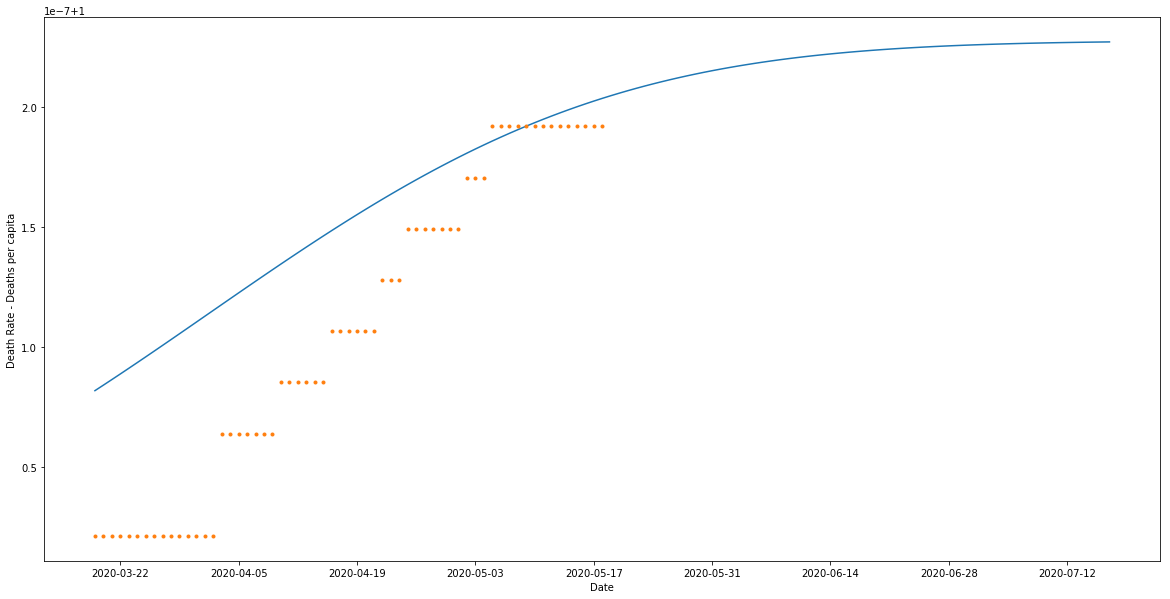

In [441]:
# Get predictions
y_pred = model.predict(
    t=df_out.time,
    group_name=df_out['group'].unique()
)

# Plot results - Death rate
plt.figure(figsize=(20,10))
plt.plot(df_out.date, np.exp(y_pred), '-')
plt.plot(df.date, np.exp(df.death_rate), '.')

plt.xlabel("Date")
plt.ylabel("Death Rate - Deaths per capita")

Text(0,0.5,'Death Rate - Deaths per capita')

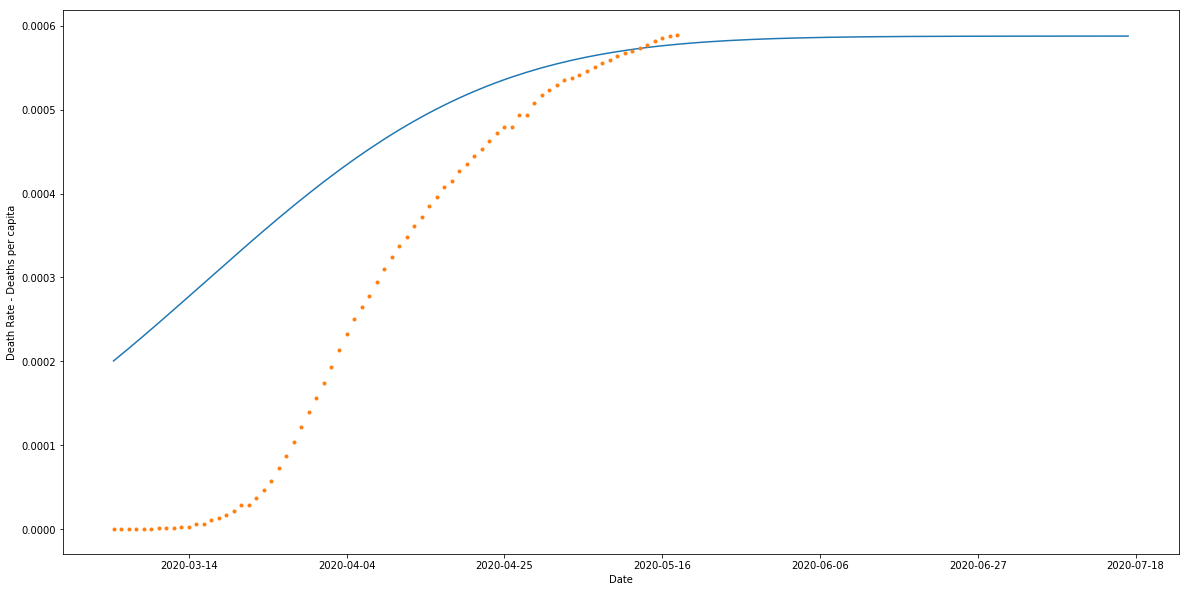

In [355]:
# Get predictions
y_pred = model.predict(
    t=df_out.time,
    group_name=df_out['group'].unique()
)

# Plot results - Death rate
plt.figure(figsize=(20,10))
plt.plot(df_out.date, y_pred, '-')
plt.plot(df.date, df.death_rate, '.')

plt.xlabel("Date")
plt.ylabel("Death Rate - Deaths per capita")

Text(0,0.5,'Death cases')

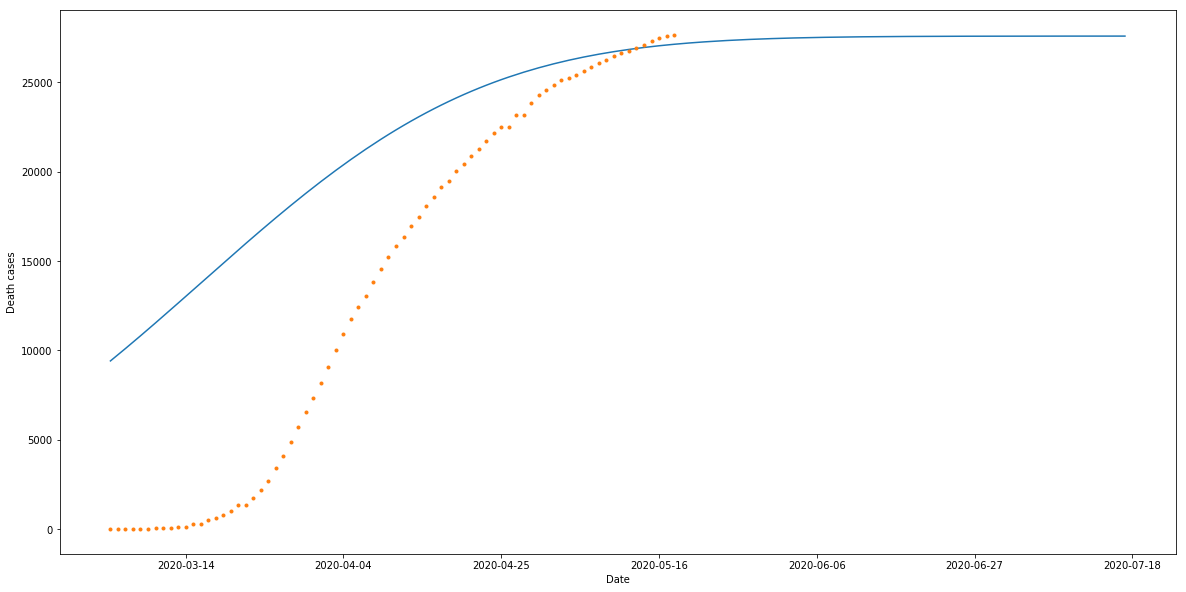

In [356]:
# Plot results - Death cases


plt.plot(df_out.date, y_pred*df_pop['Population'].values[0], '-')
plt.plot(df.date, df.death_rate*df_pop['Population'].values[0], '.')

plt.xlabel("Date")
plt.ylabel("Death cases")

In [198]:
df

,date,group,cum_deaths,intercept,time,death_rate,social_distance,social_distance2,social_distance3,diff
13698,2020-03-04,Spain,1,1.0,0,3.407155e-07,56.084,71.96,98.0,NaN
13699,2020-03-05,Spain,3,1.0,1,1.022147e-06,55.084,70.96,97.0,6.814310e-07
13700,2020-03-06,Spain,5,1.0,2,1.703578e-06,54.084,69.96,96.0,6.814310e-07
13701,2020-03-07,Spain,5,1.0,3,1.703578e-06,53.084,68.96,95.0,0.000000e+00
13702,2020-03-08,Spain,10,1.0,4,3.407155e-06,52.084,67.96,94.0,1.703578e-06
...,...,...,...,...,...,...,...,...,...,...
13769,2020-05-14,Spain,27104,1.0,71,9.234753e-03,9.018,15.39,27.0,6.269165e-05
13770,2020-05-15,Spain,27321,1.0,72,9.308688e-03,8.684,14.82,26.0,7.393526e-05
13771,2020-05-16,Spain,27459,1.0,73,9.355707e-03,8.350,14.25,25.0,4.701874e-05
13772,2020-05-17,Spain,27563,1.0,74,9.391141e-03,8.016,13.68,24.0,3.543441e-05


In [199]:
df_pop['Population'].values[0]*9.420784e-03	

27650.00104

In [ ]:
#Number of deaths = critical rate * fatality rate * population confirmed positive
{
  "all": [
    {
      "data": [
        {
          "ageGroup": "0-9",
          "isolated": 0.0,
          "confirmed": 5.0,
          "severe": 1.0,
          "critical": 5,
          "fatal": 30
        },
        {
          "ageGroup": "10-19",
          "isolated": 0.0,
          "confirmed": 5.0,
          "severe": 3.0,
          "critical": 10,
          "fatal": 30
        },
        {
          "ageGroup": "20-29",
          "isolated": 0.0,
          "confirmed": 10.0,
          "severe": 3.0,
          "critical": 10,
          "fatal": 30
        },
        {
          "ageGroup": "30-39",
          "isolated": 0.0,
          "confirmed": 15.0,
          "severe": 3.0,
          "critical": 15,
          "fatal": 30
        },
        {
          "ageGroup": "40-49",
          "isolated": 0.0,
          "confirmed": 20.0,
          "severe": 6.0,
          "critical": 20,
          "fatal": 30
        },
        {
          "ageGroup": "50-59",
          "isolated": 0.0,
          "confirmed": 25.0,
          "severe": 10.0,
          "critical": 25,
          "fatal": 40
        },
        {
          "ageGroup": "60-69",
          "isolated": 0.0,
          "confirmed": 30.0,
          "severe": 25.0,
          "critical": 35,
          "fatal": 40
        },
        {
          "ageGroup": "70-79",
          "isolated": 0.0,
          "confirmed": 40.0,
          "severe": 35.0,
          "critical": 45,
          "fatal": 50
        },
        {
          "ageGroup": "80+",
          "isolated": 0.0,
          "confirmed": 50.0,
          "severe": 50.0,
          "critical": 55,
          "fatal": 50
        }
      ],
      "name": "China CDC"
    }
  ]
}

Text(0,0.5,'Cumulative Deaths')

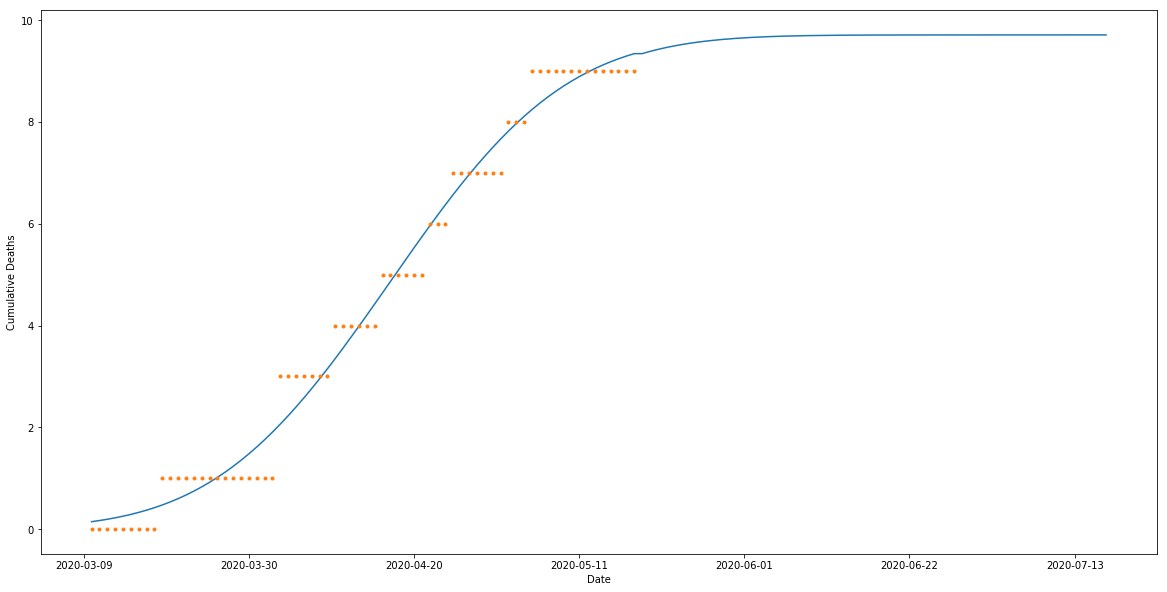

In [434]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.curvefit.core.model import CurveModel
from src.curvefit.core.functions import ln_gaussian_cdf
from src.curvefit.core.functions import gaussian_cdf

import sys
import os

import pathlib

#Importing data from all countries
file = sorted(pathlib.Path('data').iterdir(), key=os.path.getmtime)[-1]
df_all = pd.read_csv('data/'+file.name)
df_all = df_all[['day','Country Name','Cumulative Deaths']]
df_all.columns = ['date','group','cum_deaths']

region = 'Jamaica'

#If user specifies the name of a country we use the existing dataframe
if region!=None:
    df = df_all[df_all.group==region].copy()
    df.date = pd.to_datetime(df.date, format='%Y-%m-%d', errors='ignore')
#Otherwise, use the dataset uploaded by the user
else:
    df = user_df
    df.columns = ['group','date','cum_deaths']
    df.date = pd.to_datetime(df.date, format='%Y/%m/%d', errors='ignore')
    
df = df.sort_values('date')
df['time'] = range(1,df.shape[0]+1,1)
    
df['intercept'] = 1.0

# Set up the CurveModel
model = CurveModel(
    df=df,
    col_t='time',
    col_obs='cum_deaths',
    col_group='group',
    col_covs=[['intercept'], ['intercept'], ['intercept']],
    param_names=['alpha', 'beta', 'p'],
    link_fun=[lambda x: x, lambda x: x, lambda x: x],
    var_link_fun=[lambda x: x, lambda x: x, lambda x: x],
    fun=gaussian_cdf
)

# Fit the model to estimate parameters
model.fit_params(fe_init=[0, 0, 1.],
                 fe_gprior=[[0, np.inf], [0, np.inf], [1., np.inf]])

df_out = pd.DataFrame({'time':df.time.tolist() + list(range(df.shape[0],60+df.shape[0],1))})
df_out['group'] = df.group.unique()[0]
df_out['date'] = pd.date_range(start=df.date.unique()[0],periods=df_out.shape[0])

# Get predictions
y_pred = model.predict(
    t=df_out.time,
    group_name=df_out['group'].unique()
)

# Plot results
plt.figure(figsize=(20,10))
plt.plot(df_out.date, y_pred, '-')
plt.plot(df.date, df.cum_deaths, '.')

plt.xlabel("Date")
plt.ylabel("Cumulative Deaths")

Text(0,0.5,'Cumulative Deaths')

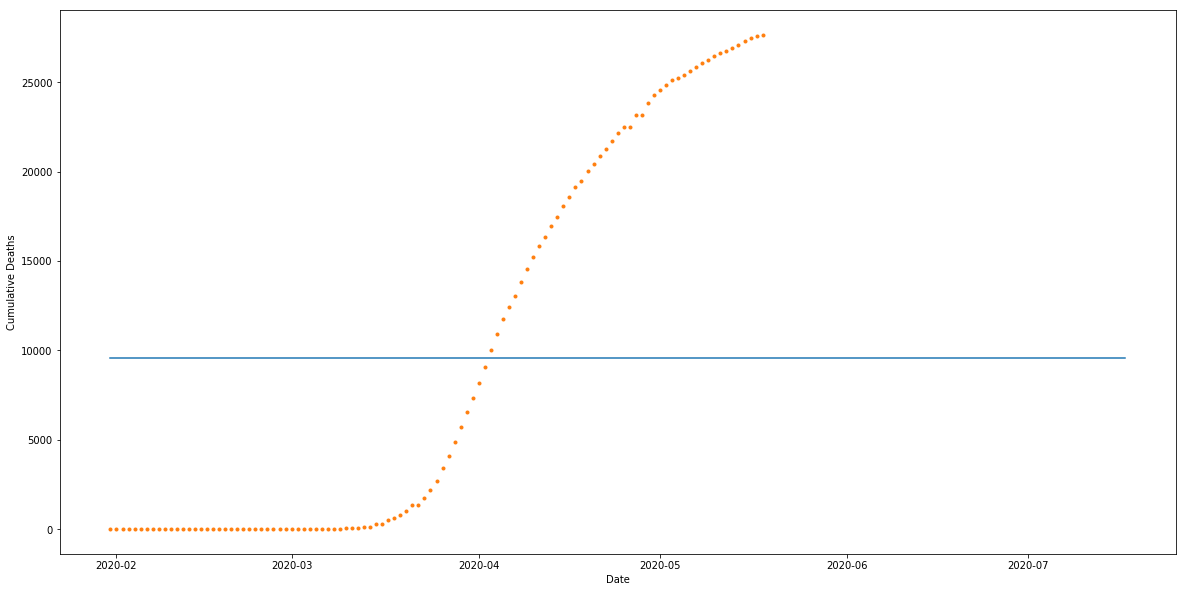

In [442]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.curvefit.core.model import CurveModel
from src.curvefit.core.functions import ln_gaussian_cdf
from src.curvefit.core.functions import gaussian_cdf

import sys
import os

import pathlib

#Importing data from all countries
file = sorted(pathlib.Path('data').iterdir(), key=os.path.getmtime)[-1]
df_all = pd.read_csv('data/'+file.name)
df_all = df_all[['day','Country Name','Cumulative Deaths']]
df_all.columns = ['date','group','cum_deaths']

region = 'Spain'

#If user specifies the name of a country we use the existing dataframe
if region!=None:
    df = df_all[df_all.group==region].copy()
    df.date = pd.to_datetime(df.date, format='%Y-%m-%d', errors='ignore')
#Otherwise, use the dataset uploaded by the user
else:
    df = user_df
    df.columns = ['group','date','cum_deaths']
    df.date = pd.to_datetime(df.date, format='%Y/%m/%d', errors='ignore')
    
df = df.sort_values('date')
df['time'] = range(1,df.shape[0]+1,1)
    
df['intercept'] = 1.0

# Set up the CurveModel
model = CurveModel(
    df=df,
    col_t='time',
    col_obs='cum_deaths',
    col_group='group',
    col_covs=[['intercept'], ['intercept'], ['intercept']],
    param_names=['alpha', 'beta', 'p'],
    link_fun=[lambda x: x, lambda x: x, lambda x: x],
    var_link_fun=[lambda x: x, lambda x: x, lambda x: x],
    fun=gaussian_cdf
)

# Fit the model to estimate parameters
model.fit_params(fe_init=[0, 0, 1.],
                 fe_gprior=[[0, np.inf], [0, np.inf], [1., np.inf]])

df_out = pd.DataFrame({'time':df.time.tolist() + list(range(df.shape[0],60+df.shape[0],1))})
df_out['group'] = df.group.unique()[0]
df_out['date'] = pd.date_range(start=df.date.unique()[0],periods=df_out.shape[0])

# Get predictions
y_pred = model.predict(
    t=df_out.time,
    group_name=df_out['group'].unique()
)

# Plot results
plt.figure(figsize=(20,10))
plt.plot(df_out.date, y_pred, '-')
plt.plot(df.date, df.cum_deaths, '.')

plt.xlabel("Date")
plt.ylabel("Cumulative Deaths")